In [306]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops
import tensorflow.keras as keras

np.random.seed(1)

In [307]:
# Function for loading dataset
def load_dataset():
    
    # load training set
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_x_raw = np.array(train_dataset["train_set_x"][:])
    train_y_raw = np.array(train_dataset["train_set_y"][:])
    
    # load test set
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_x_raw = np.array(test_dataset["test_set_x"][:])
    test_y_raw = np.array(test_dataset["test_set_y"][:])
    
    # get list of classes (0 to 5)
    classes = np.array(test_dataset["list_classes"][:])
    
    # reshape y sets into [1, # of samples]
    train_y_raw = train_y_raw.reshape((1, train_y_raw.shape[0]))
    test_y_raw = test_y_raw.reshape((1, test_y_raw.shape[0]))
    
    return train_x_raw, train_y_raw, test_x_raw, test_y_raw, classes

In [308]:
# Load data
X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, classes = load_dataset()

In [309]:
# Function for one-hot-encoding Y datasets
def one_hot_encode(Y, num_classes):
    Y = np.eye(num_classes)[Y.reshape(-1)].T
    return Y

In [310]:
# Normalize X datasets (255 RGB values)
X_train = X_train_raw / 255
X_test = X_test_raw / 255

# One-Hot Encode Y datasets
Y_train = one_hot_encode(Y_train_raw, 6).T
Y_test = one_hot_encode(Y_test_raw, 6).T

In [311]:
# Function for initializing placeholders X, Y 
def init_placeholders(n_h_raw, n_w_raw, n_c_raw, n_y_raw):
    
    X = tf.placeholder(tf.float32, shape=(None, n_h_raw, n_w_raw, n_c_raw), name="X")
    Y = tf.placeholder(tf.float32, shape=(None, n_y_raw), name="Y")
    
    return X, Y

In [312]:
# Function for initializing parameters W1, W2 using xavier/GlorotUniform initialization
def init_parameters(w1_hw, w1_c, w1_n, w2_hw, w2_c, w2_n):
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [w1_hw, w1_hw, w1_c, w1_n], initializer = keras.initializers.GlorotUniform(seed=0))
    W2 = tf.get_variable("W2", [w2_hw, w2_hw, w2_c, w2_n], initializer = keras.initializers.GlorotUniform(seed=0))
    
    parameters = {"W1" : W1, 
                  "W2" : W2}
    
    return parameters

In [313]:
# Function for forward propagation
def fwd_prop(X, parameters):
    
    # Get parameters
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    ### LAYER I ###
    # 2D Convolutional
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    # ReLU
    A1 = tf.nn.relu(Z1)
    # Max Pooling
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    
    ### LAYER II ###
    # 2D Convolutional
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
    # ReLU
    A2 = tf.nn.relu(Z2)
    # Max Pooling
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    
    ### LAYER III ###
    # Flatten
    F = keras.layers.Flatten()(P2)
    # Fully-Connected
    Z3 = keras.layers.Dense(6, activation=None)(F)

    return Z3

In [314]:
# Compute the cost
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [315]:
# Function to return a list of random mini-batches
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle X, Y
    permutation = list(np.random.permutation(m))
    X_shuffled = X[permutation,:,:,:]
    Y_shuffled = Y[permutation,:]
    
    # Partition (excluding end case)
    num_full_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_full_minibatches):
        mini_batch_X = X_shuffled[k*mini_batch_size : k*mini_batch_size+mini_batch_size,:,:,:]
        mini_batch_Y = Y_shuffled[k*mini_batch_size : k*mini_batch_size+mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # End case
    if m % mini_batch_size != 0:
        mini_batch_X = X_shuffled[num_full_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = Y_shuffled[num_full_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [317]:
# Model
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed = 3
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    # Initialize placeholders
    X, Y = init_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Initialize parameters
    parameters = init_parameters(4, 3, 8, 2, 8, 16)
    
    # Forward propagation
    Z3 = fwd_prop(X, parameters)
    
    # Cost function
    cost = compute_cost(Z3, Y)
    
    # Backward propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all variables globally
    init = tf.global_variables_initializer()
    
    # Start session
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            # Print updates
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        # Plot learning rate
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Iterations (per tens)')
        plt.title("Learning Rate =" + str(learning_rate))
        plt.grid(b=None, which='major')
        plt.show()
            
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters       

Cost after epoch 0: 1.912231
Cost after epoch 5: 1.569796
Cost after epoch 10: 1.066529
Cost after epoch 15: 0.843855
Cost after epoch 20: 0.624951
Cost after epoch 25: 0.543978
Cost after epoch 30: 0.439285
Cost after epoch 35: 0.385301
Cost after epoch 40: 0.428603
Cost after epoch 45: 0.342247
Cost after epoch 50: 0.302320
Cost after epoch 55: 0.257061
Cost after epoch 60: 0.226683
Cost after epoch 65: 0.243921
Cost after epoch 70: 0.247451
Cost after epoch 75: 0.191771
Cost after epoch 80: 0.191226
Cost after epoch 85: 0.170718
Cost after epoch 90: 0.132281
Cost after epoch 95: 0.142768


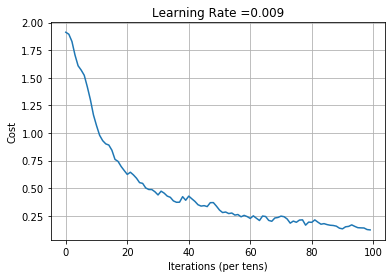

Train Accuracy: 0.9722222
Test Accuracy: 0.7583333


In [318]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)